## ECG CNN Code adapted for ECG_5000 dataset

In [28]:
import numpy as np 
import pandas as pd 

import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from scipy import stats

from sklearn.utils import resample
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.utils import class_weight

import keras
from keras.models import Sequential
from keras.layers import Conv1D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from keras import regularizers

from tensorflow.keras.optimizers import Adam 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import Input

%matplotlib inline

**Load ECG 500 Data**

In [29]:
X = list()
y = list()

# Load data
ECGdataset_train = pickle.load(open('ECG_5000_Dataset/ECG5000_train.pickle', "rb"), encoding='latin1')
ECGdataset_val = pickle.load(open('ECG_5000_Dataset/ECG5000_validation.pickle', "rb"), encoding='latin1')

X_train_df = pd.DataFrame(ECGdataset_train)
X_test_df = pd.DataFrame(ECGdataset_val) # This code used the term test in place of validation

print(f"X_train: {X_train_df.shape}")
print(f"X_test: {X_test_df.shape}")

X_train: (500, 141)
X_test: (1500, 141)


**Display pie chart of distribution of classes in the training dataset**

0
0.0    292
1.0    177
3.0     19
2.0     10
4.0      2
Name: count, dtype: int64


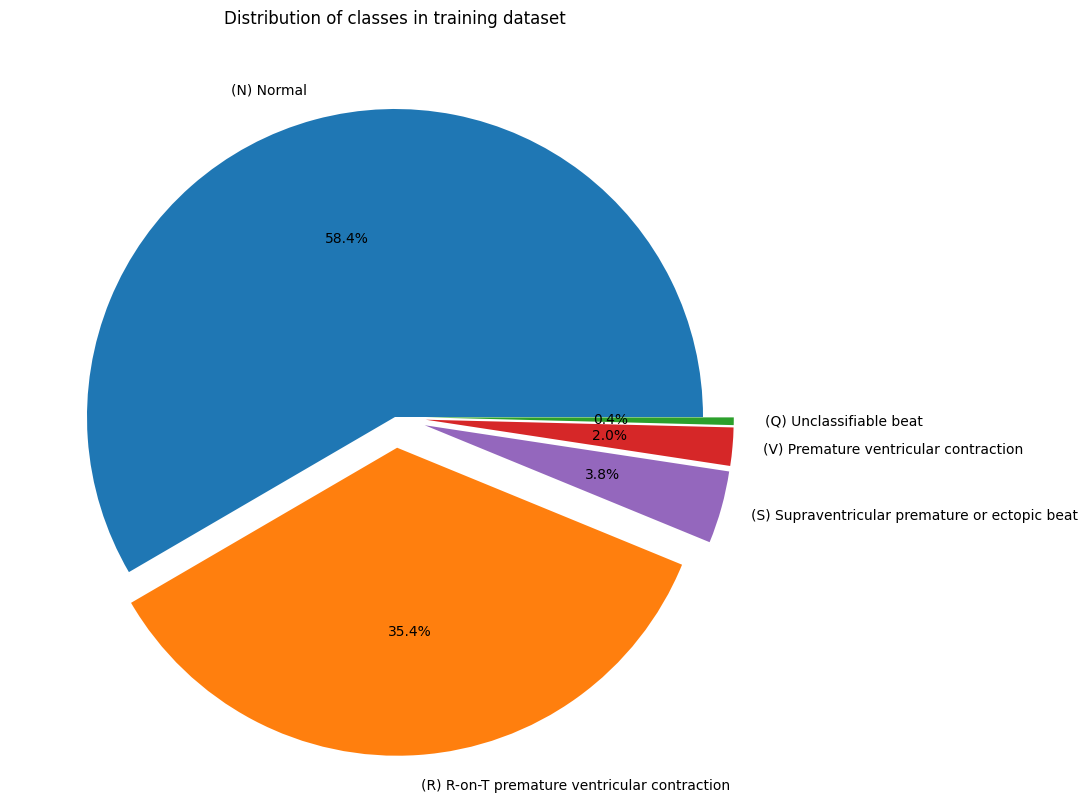

In [30]:
# Count entries per class
per_class = X_train_df.iloc[:, 0].value_counts()
print(per_class)

# Display them in a pie plot
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
explode=(0,0.1,0.1,0.1,0.1)
plt.title("Distribution of classes in training dataset")
plt.pie(per_class, labels=['(N) Normal', '(R) R-on-T premature ventricular contraction', '(S) Supraventricular premature or ectopic beat', '(V) Premature ventricular contraction', '(Q) Unclassifiable beat'],explode=explode, colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')
plt.show()

**Resampling to even the distribution of classes**

(292, 141) (177, 141) (10, 141) (19, 141) (2, 141)
0
0.0    100
1.0    100
2.0    100
3.0    100
4.0    100
Name: count, dtype: int64


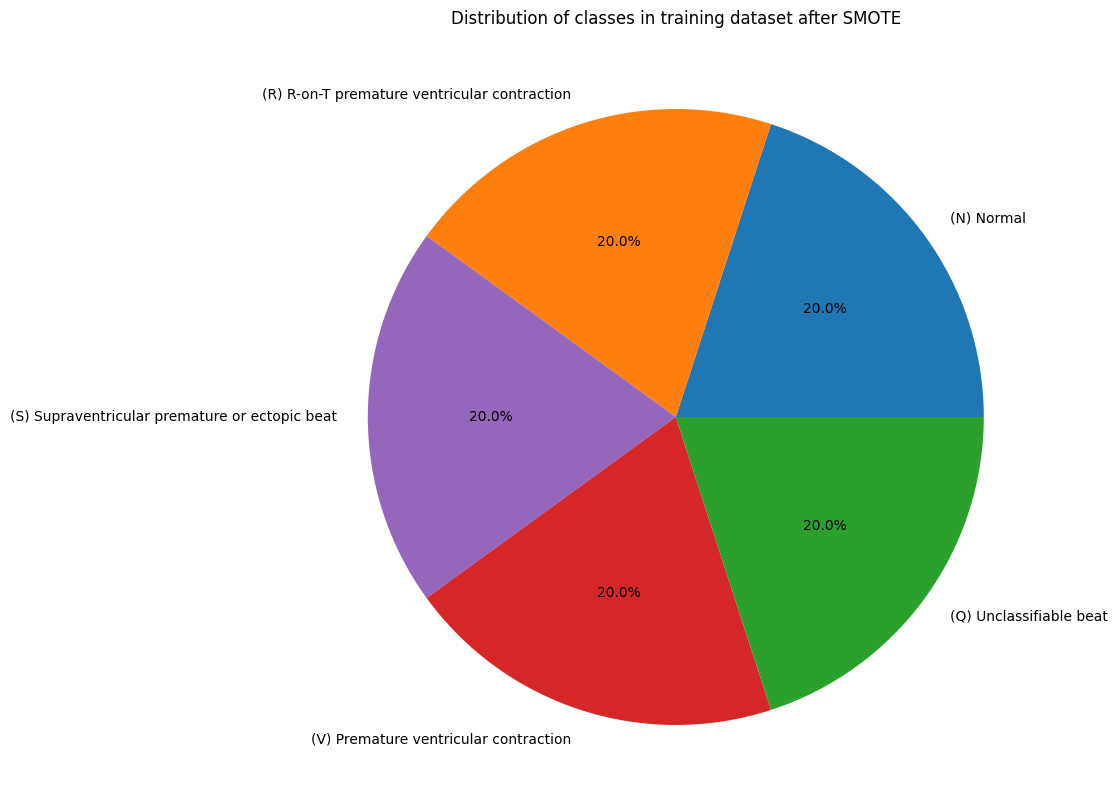

In [31]:
# seperate labels
target = X_train_df.iloc[:, 0]

# Separate by label using boolean indexing
df_0 = X_train_df[target == 0]
df_1 = X_train_df[target == 1]
df_2 = X_train_df[target == 2]
df_3 = X_train_df[target == 3]
df_4 = X_train_df[target == 4]

# Print the shapes of the separated DataFrames
print(df_0.shape, df_1.shape, df_2.shape, df_3.shape, df_4.shape)

# Number of entries to have in each class
countclassno = 100

# SMOTE
df_0_undersample = df_0.sample(countclassno,replace=True)
df_1_undersample = df_1.sample(countclassno,replace=True)
df_2_undersample = df_2.sample(countclassno,replace=True)
df_3_undersample = df_3.sample(countclassno,replace=True)
df_4_undersample = df_4.sample(countclassno,replace=True)

# Recombine data 
X_train_df=pd.concat([df_0_undersample, df_1_undersample, df_2_undersample, df_3_undersample, df_4_undersample])

# Count entries per class
per_class = X_train_df.iloc[:, 0].value_counts()
print(per_class)

plt.figure(figsize=(20,10))
plt.title("Distribution of classes in training dataset after SMOTE")
plt.pie(per_class, labels=['(N) Normal', '(R) R-on-T premature ventricular contraction', '(S) Supraventricular premature or ectopic beat', '(V) Premature ventricular contraction', '(Q) Unclassifiable beat'], colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')
plt.show()

In [32]:
# Segment label data based on train / test split
target_train = X_train_df.iloc[:, 0] # Index 0 is labels
target_test = X_test_df.iloc[:, 0] # Index 0 is labels

train_y = to_categorical(target_train)
test_y = to_categorical(target_test)


train_x = X_train_df.iloc[:, 1:141] # Index 1 - 140 is features
test_x = X_test_df.iloc[:, 1:141] # Index 1 - 140 is features

# Reset the indexes
train_x = train_x.reset_index(drop=True)
test_x = test_x.reset_index(drop=True)

# Computing mean and standard deviation of training set
train_mean = train_x.mean()
train_std = train_x.std()

# Apply same stnadardization to both sets
train_x = (train_x - train_mean) / train_std
test_x = (test_x - train_mean) / train_std

# Display shapes
print(f"Y_train: {np.shape(train_y)}")
print(f"Y_test: {np.shape(test_y)}")

print("X before reshape:")
print(f"\nX_train: {np.shape(train_x)}")
print(f"X_test: {np.shape(test_x)}")

# Reshape to be 3D
train_x = train_x.values.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.values.reshape(len(test_x), test_x.shape[1],1)

print("X after reshape:")
print("X_train : ", np.shape(train_x))
print("X_test  : ", np.shape(test_x))

Y_train: (500, 5)
Y_test: (1500, 5)
X before reshape:

X_train: (500, 140)
X_test: (1500, 140)
X after reshape:
X_train :  (500, 140, 1)
X_test  :  (1500, 140, 1)


**Build Neural Network**

In [33]:
model = Sequential()

model.add(Input(shape=(140, 1)))
model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
model.add(AvgPool1D(pool_size=3, strides=2))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
model.add(Softmax())
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)               │ (None, 140, 16)        │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_9             │ (None, 69, 16)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 69, 64)         │        17,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_10            │ (None, 34, 64)         │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 34, 128)        │       155,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling1d_11            │ (None, 16, 128)        │             0 │
│ (AveragePooling1D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 35)             │        71,715 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ softmax_3 (Softmax)             │ (None, 5)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 245,367 (958.46 KB)

 Trainable params: 245,367 (958.46 KB)

 Non-trainable params: 0 (0.00 B)

**Compile and fit model**

In [34]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# Define the checkpoint callback
checkpoint = ModelCheckpoint(
    filepath='model/best_model.weights.h5',  # Path to save the weights
    monitor='val_accuracy',                  # Metric to monitor (e.g., 'val_loss' or 'val_accuracy')
    save_best_only=True,                     # Save only the best weights
    save_weights_only=True,                  # Save only weights, not the full model
    verbose=1                                # Print messages when saving
)

# Set learning rate
learning_rate = 0.001
optimizer = Adam(learning_rate=learning_rate)

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Fit the model with the checkpoint callback
modelbase = model.fit(
    train_x, train_y,
    batch_size=100, # defualt is 36
    epochs=50,
    verbose=1,
    validation_data=(test_x, test_y),
    callbacks=[checkpoint]  # Add the checkpoint callback here
)

# Save the final model to disk
model.save("model/final_model.keras")
# Load the saved weights for the epoch with the lowest validation loss
model.load_weights('model/best_model.weights.h5')
print("Saved final model to disk")

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.4869 - loss: 1.4494
Epoch 1: val_accuracy improved from -inf to 0.80400, saving model to model/best_model.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 380ms/step - accuracy: 0.5117 - loss: 1.4205 - val_accuracy: 0.8040 - val_loss: 0.7664
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7700 - loss: 0.7193
Epoch 2: val_accuracy did not improve from 0.80400
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - accuracy: 0.7744 - loss: 0.7091 - val_accuracy: 0.7987 - val_loss: 0.7036
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.8575 - loss: 0.3966
Epoch 3: val_accuracy did not improve from 0.80400
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 538ms/step - accuracy: 0.8579 - loss: 0.3998 - val_accuracy: 0.7447 - val_loss: 0.8319
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.8308 - loss: 0.4385
Epoch 4: val_accuracy improved from 0.80400 to 0.83800, saving model to model/best_model.weights.h5
5/5 ━━━━━━━━━━━━━━━━━━━━

**Plot**

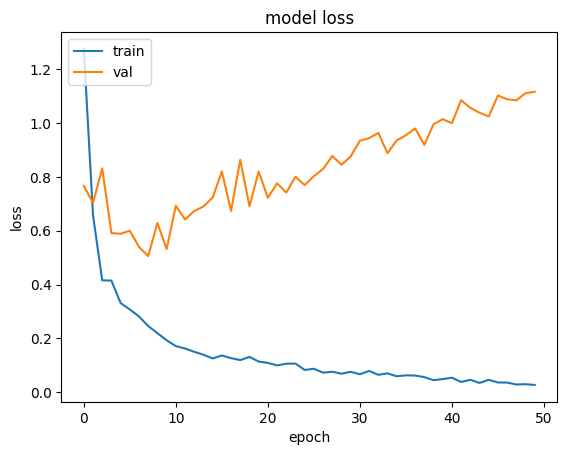

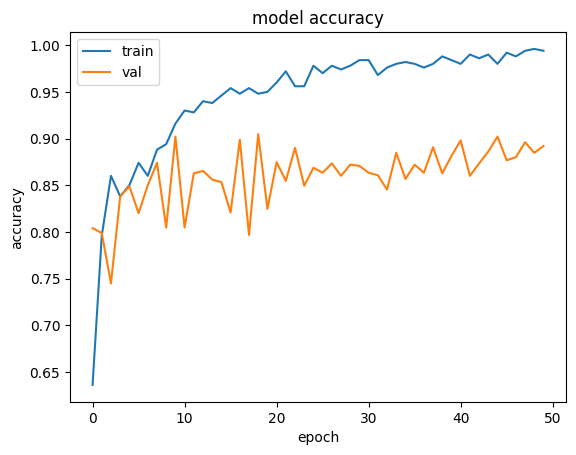

In [35]:
# Plot Loss
plt.plot(modelbase.history['loss'])
plt.plot(modelbase.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plot Accuracy
plt.plot(modelbase.history['accuracy'])
plt.plot(modelbase.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [36]:
score = model.evaluate(test_x, test_y)
y_pred = model.predict(test_x)

print('Test Loss:', score[0])
print('Test accuracy:', score[1])

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9719 - loss: 0.1797
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Loss: 0.6912841796875
Test accuracy: 0.9046666622161865


**Plot Confusion Matrix**

Accuracy: 0.9047
Precision (macro): 0.6384
Recall (macro): 0.5984
F1 Score (macro): 0.6093
Confusion Matrix:
[[773   0   3   4   1]
 [ 16 524   6  44   0]
 [ 10   8  16   7   2]
 [  2  27   3  42   1]
 [  3   4   2   0   2]]


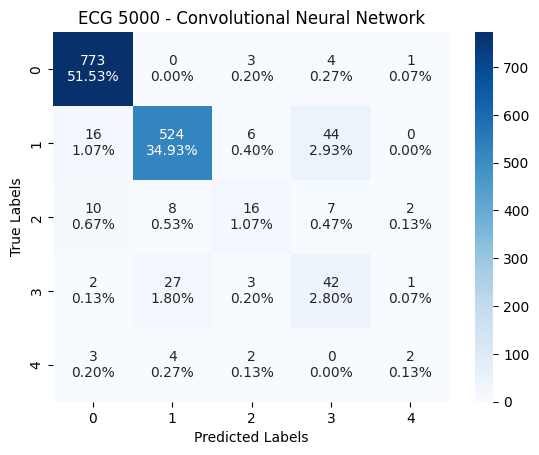

In [37]:
# Make predictions for validation set
val_y_predictions = y_pred.argmax(axis=1)
ECGdataset_val_y_flat = test_y.argmax(axis=1)


# Calculate metrics
accuracy = accuracy_score(ECGdataset_val_y_flat, val_y_predictions)
precision = precision_score(ECGdataset_val_y_flat, val_y_predictions, average='macro', zero_division=1)
recall = recall_score(ECGdataset_val_y_flat, val_y_predictions, average='macro')
f1 = f1_score(ECGdataset_val_y_flat, val_y_predictions, average='macro')
conf_matrix = confusion_matrix(ECGdataset_val_y_flat, val_y_predictions)

#Print metrics
print("Accuracy: {:.4f}".format(accuracy))
print("Precision (macro): {:.4f}".format(precision))
print("Recall (macro): {:.4f}".format(recall))
print("F1 Score (macro): {:.4f}".format(f1))
print("Confusion Matrix:")
print(conf_matrix)

model_performance = [accuracy, precision, recall, f1]
cf_matrix = np.array(conf_matrix)



plt.figure(dpi=100)

group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
labels = [f"{v1}\n{v2}" for v1, v2, in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(5,5)
plt.title("ECG 5000 - Convolutional Neural Network")
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()